In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install & Imports

In [2]:
!pip install xgboost --quiet

In [3]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns


Load data

In [4]:
price_data = pd.read_csv(
    '/content/drive/MyDrive/Coffee/Dev/C2/Data/coffee_price_simulation/coffee_price_monthly_dataset_CORRECTED.csv'
)

price_data.head()

,year,month,yield_source,predicted_yield_kg,global_price_usd_kg,usd_lkr_rate,demand_index,local_coffee_price_lkr_per_kg
0,2023.0,1.0,historical,573.95,3.504190,365.0,1.12,1565.97
1,2023.0,2.0,historical,667.74,3.996257,362.0,0.99,1345.70
2,2023.0,3.0,historical,684.29,3.888009,324.0,1.03,1189.67
3,2023.0,4.0,historical,590.14,4.142765,320.0,1.06,1494.00
4,2023.0,5.0,historical,720.92,4.060391,290.0,0.99,1014.55


Feature Engineering

In [5]:
price_data['month_sin'] = np.sin(2 * np.pi * price_data['month'] / 12)
price_data['month_cos'] = np.cos(2 * np.pi * price_data['month'] / 12)

Define Features & Target

In [6]:
# Target Variable
TARGET = 'local_coffee_price_lkr_per_kg'

# Input Features
FEATURES = [
    'predicted_yield_kg',
    'global_price_usd_kg',
    'usd_lkr_rate',
    'demand_index',
    'month_sin',
    'month_cos'
]

X = price_data[FEATURES]
y = price_data[TARGET]

Train / Validation Split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.25,
    shuffle=False
)


Define Advanced XGBoost Model

In [8]:
model = XGBRegressor(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)


Train the Model

In [9]:
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

Model Evaluation

In [10]:
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE  : {mae:.2f} LKR/kg")
print(f"RMSE : {rmse:.2f} LKR/kg")
print(f"R²   : {r2:.3f}")

MAE  : 557.81 LKR/kg
RMSE : 799.84 LKR/kg
R²   : 0.586


Actual vs Predicted Plot

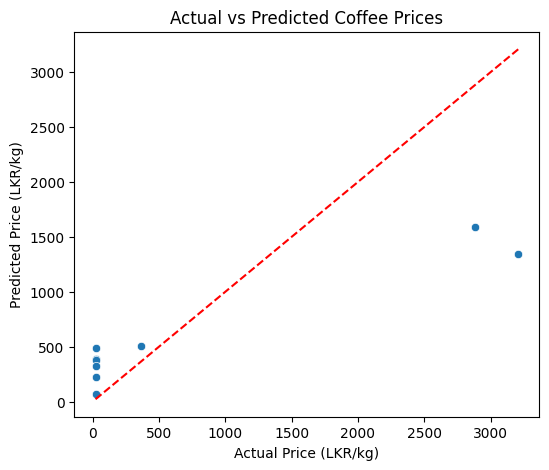

In [11]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    'r--'
)
plt.xlabel("Actual Price (LKR/kg)")
plt.ylabel("Predicted Price (LKR/kg)")
plt.title("Actual vs Predicted Coffee Prices")
plt.show()

Feature Importance

In [12]:
importance = model.feature_importances_

imp_df = pd.DataFrame({
    'feature': FEATURES,
    'importance': importance
}).sort_values(by='importance', ascending=False)

imp_df

,feature,importance
1,global_price_usd_kg,0.414246
2,usd_lkr_rate,0.357871
0,predicted_yield_kg,0.118437
4,month_sin,0.076635
3,demand_index,0.017954
5,month_cos,0.014857


Plot Feature Importance

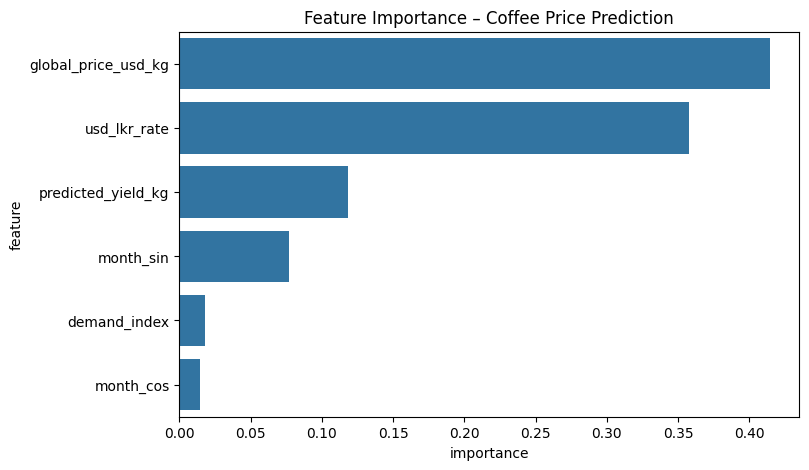

In [13]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x='importance',
    y='feature',
    data=imp_df
)
plt.title("Feature Importance – Coffee Price Prediction")
plt.show()

Save Trained Price Model

In [14]:
import joblib

joblib.dump(
    model,
    '/content/drive/MyDrive/Coffee/Dev/C2/coffee_price_xgboost_model.pkl'
)

print("Price prediction model saved")

Price prediction model saved


Predict Future Prices (2025–2026)

In [15]:
future_data = price_data.copy()

future_X = future_data[FEATURES]
future_data['predicted_price_lkr_per_kg'] = model.predict(future_X).round(2)

future_data[
    ['year', 'month', 'predicted_price_lkr_per_kg']
].tail()

,year,month,predicted_price_lkr_per_kg
31,2025.0,8.0,377.579987
32,2025.0,9.0,324.350006
33,2025.0,10.0,505.820007
34,2025.0,11.0,1347.900024
35,2025.0,12.0,1590.390015


Save Price Forecasts

In [16]:
future_data.to_csv(
    '/content/drive/MyDrive/Coffee/Dev/C2/coffee_price_predictions_2025_2026.csv',
    index=False
)

print("Price predictions saved")

Price predictions saved
